In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from batch_norm_vgg import VGG, make_layers, make_layers_BN
from batch_norm_callbacks import ICS, AccuracyList
import matplotlib.pyplot as plt
from operator import add, neg

In [2]:
data_path = untar_data(URLs.CIFAR)

In [3]:
data_path.ls()

[PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/test'),
 PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/train'),
 PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/labels.txt'),
 PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/models')]

In [4]:
data = ImageDataBunch.from_folder(
                data_path, valid='test', size=32, bs=128)
#             ).split_by_idxs(
#                 train_idx=[0, 1, 2, 3, 4, 5, 5000, 5001, 5002,5003,5004,5005], valid_idx=[0, 1, 2, 3, 4, 5, 1000,1001, 1002,1003,1004,1005]
#             ).label_from_folder(
#             ).databunch(bs=2, num_workers=1, no_check=True)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD

In [6]:
# Debug hook

# def print_input(self, input, output):
#     print(self.running_mean)

# convHook = callbacks.Hook(vgg.features[9], print_input, detach=False)

In [7]:
@dataclass
class LossVariation(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.loss_var = []
        self.losses = []
        self.old_loss = 0
        
    def on_backward_begin(self, last_loss, **kwargs):
        current_loss = last_loss.data.clone()
        self.loss_var.append((self.old_loss - current_loss).norm(2).cpu().numpy())
        self.losses.append(current_loss.cpu().numpy())
        self.old_loss = current_loss

In [8]:
@dataclass
class GradVariation(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.grad_var = []
        self.grad_smoothness = []
        self.grads_l2 = []
        self.grads_l1 = []
        self.grads = []
        self.old_grad = None
        self.first_step = True
        
        conv_layer_pos = 5
        conv_counter = 0
        self.grad_layer_pos = 0
        for i, p in enumerate(self.learn.model.features):
            if isinstance(p, nn.modules.Conv2d):
                conv_counter += 1
            if conv_counter == conv_layer_pos:
                self.grad_layer_pos = i
                break
                
        
    def on_backward_end(self, **kwargs): 
        wg = self.learn.model.features[self.grad_layer_pos].weight.grad
        if not self.first_step:
            self.grad_var.append((self.old_grad + wg).abs().mean())
            self.grads_l2.append(wg.norm(2))
            self.grads_l1.append(wg.norm(1))
            #self.grads.append(wg.data.clone())
            #self.grad_smoothness.append(torch.max((self.old_grad - wg).norm(2)))
        self.old_grad = wg.data.clone()
        self.first_step = False

In [9]:
vgg = VGG(make_layers(batch_norm=False), num_classes=data.c).cuda()

learn_vgg = Learner(data, vgg, opt_func=optimizer,
                               loss_func=criterion,
                               true_wd=False,
                               wd=0.,
                               bn_wd=False,
                               metrics=accuracy)

lossVar_noBN = LossVariation(learn_vgg)
gradVar_noBN = GradVariation(learn_vgg)

learn_vgg.fit(3, lr=0.1, callbacks=[lossVar_noBN, gradVar_noBN])

epoch,train_loss,valid_loss,accuracy,time
0,2.280813,2.311392,0.100000,00:32
1,2.137560,2.234054,0.158600,00:33
2,1.845817,1.695600,0.357500,00:33


In [10]:
vgg = VGG(make_layers(batch_norm=True), num_classes=data.c).cuda()

learn_vgg = Learner(data, vgg, opt_func=optimizer,
                               loss_func=criterion,
                               true_wd=False,
                               wd=0.,
                               bn_wd=False,
                               metrics=accuracy)

lossVar_BN = LossVariation(learn_vgg)
gradVar_BN = GradVariation(learn_vgg)

learn_vgg.fit(3, lr=0.1, callbacks=[lossVar_BN, gradVar_BN])

epoch,train_loss,valid_loss,accuracy,time
0,1.637015,1.859306,0.325200,00:33
1,1.299438,1.313999,0.530700,00:34
2,1.056678,1.026223,0.642900,00:34


In [11]:
torch.relu(torch.tensor([-1]))

tensor([0])

In [12]:
v = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
n = torch.tensor([[-2,2,2],[3,-3,3], [1,2,-1]], dtype=torch.float)
v+n

tensor([[-1.,  4.,  5.],
        [ 7.,  2.,  9.],
        [ 8., 10.,  8.]])

In [13]:
torch.relu((v*n).neg()).mean()

tensor(2.8889)

In [14]:
torch.relu((v-n).abs())

tensor([[ 3.,  0.,  1.],
        [ 1.,  8.,  3.],
        [ 6.,  6., 10.]])

In [15]:
(v+n).abs().mean()

tensor(6.)

In [16]:
v2 = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
n2 = torch.tensor([[2,2,2],[3,3,3], [1,2,1]], dtype=torch.float)
v2*n2

tensor([[ 2.,  4.,  6.],
        [12., 15., 18.],
        [ 7., 16.,  9.]])

In [17]:
torch.relu((v2*n2).neg()).mean()

tensor(0.)

In [18]:
(v2+n2).abs().mean()

tensor(7.1111)

In [19]:
v3 = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
n3 = torch.tensor([[-2,-2,-2],[-3,-3,-3], [-1,-2,-1]], dtype=torch.float)
v3+n3

tensor([[-1.,  0.,  1.],
        [ 1.,  2.,  3.],
        [ 6.,  6.,  8.]])

In [20]:
((torch.relu((v3*n3).neg())/n3) - n3).norm(2)

tensor(12.3288)

In [21]:
(v3+n3).abs().mean()

tensor(3.1111)

In [22]:
gradVar_BN.grad_var

[tensor(0.0010, device='cuda:0'),
 tensor(0.0011, device='cuda:0'),
 tensor(0.0008, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0007, device='cuda:0'),
 tensor(0.0010, device='cuda:0'),
 tensor(0.0010, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0007, device='cuda:0'),
 tensor(0.0007, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0006, device='cuda:0'),
 tensor(0.0007

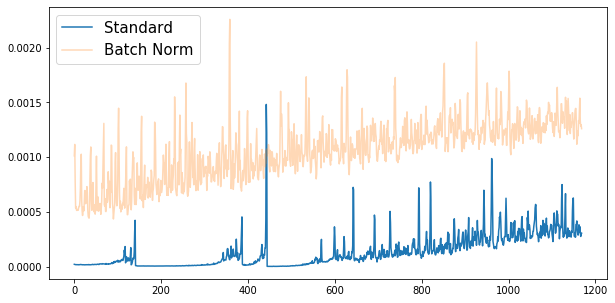

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

plt.plot(gradVar_noBN.grad_var, label="Standard")
plt.plot(gradVar_BN.grad_var, label="Batch Norm",alpha=.3)

ax.legend(fontsize=15)

plt.savefig('grad.pdf')
plt.savefig('grad.png')

In [24]:
from scipy.stats import entropy

In [25]:
noBN_y1 = lossVar_noBN.losses[10:]
noBN_y2 = list(map(add,lossVar_noBN.losses[10:], lossVar_noBN.loss_var[10:]))
noBN_x = list(range(len(lossVar_noBN.losses[10:])))

In [26]:
import numpy as np
np.var(lossVar_noBN.losses)

0.030815419

In [27]:
BN_y1 = lossVar_BN.losses[10:]
BN_y2 = list(map(add,lossVar_BN.losses[10:], lossVar_BN.loss_var[10:]))
BN_x = list(range(len(lossVar_BN.losses[10:])))

In [28]:
np.var(lossVar_BN.losses)

0.12033432

In [29]:
entropy(lossVar_noBN.losses, base=2)

10.1874583651964

In [30]:
entropy(lossVar_BN.losses, base=2)

10.152495668137199

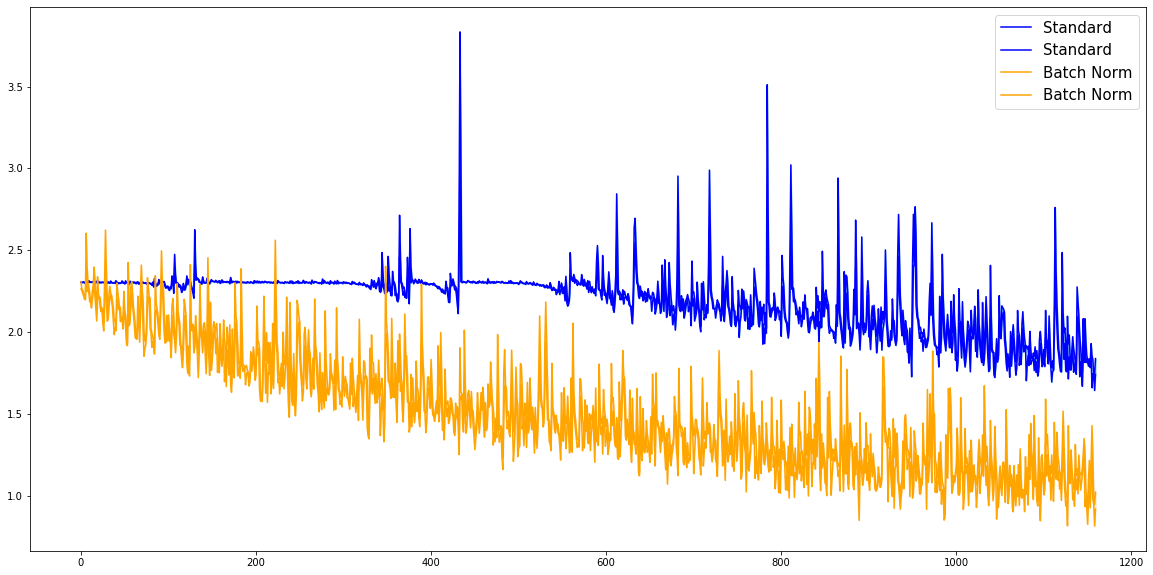

In [31]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

plt.plot(noBN_y1, label="Standard", color="Blue")
ax.fill_between(noBN_x, noBN_y1, noBN_y2, color="skyblue")
plt.plot(noBN_y2, label="Standard", color="Blue")

plt.plot(BN_y1, label="Batch Norm", color="Orange")
ax.fill_between(BN_x, BN_y1, BN_y2, color="bisque")
plt.plot(BN_y2, label="Batch Norm", color="Orange")
ax.legend(fontsize=15)

plt.savefig('loss.pdf')
plt.savefig('loss.png')